# Adaptive Scale Selection AMPD (ASS-AMPD)
Here, we look into signals that are quasi-periodic locally, but have variable scale across the timeseries

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
from numpy import sin, pi
from scipy.signal import find_peaks_cwt
from ampd import find_peaks_ampd, find_peaks_ampd_original, find_peaks_ass_ampd
import matplotlib.pyplot as plt

## Create fake signal

In [35]:
def fake_timeseries(tmax=30, seed=None, dilation=1.):
    """Generate fake data for testing peak detection algorithms"""
    np.random.seed(seed)
    fs, f1, f2, f3 = 20, dilation * 1, dilation * 2, dilation * 0.1
    a, b, c, d = 1, 0.6, 1, 1.
    N = int(tmax*fs)
    t = np.linspace(0, tmax, N)
    x = a*sin(2*pi*f1*t) + b*sin(2*pi*f2*t) + c*sin(2*pi*f3*t) + d*np.random.rand(N)
    return t, x

## Compare peak detect methods

In [36]:
methods = [
    ('ass_ampd_50', lambda x: find_peaks_ass_ampd(x, window=50)),
    ('ass_ampd_100', lambda x: find_peaks_ass_ampd(x, window=100)),
    ('ass_ampd_200', lambda x: find_peaks_ass_ampd(x, window=200)),
    ('ampd', find_peaks_ampd)
]
styles = ['rs', 'go', 'bx', 'cs', 'mo']

### Create a signal with distinct regions characterised by different frequency/scale content

In [37]:
t1, x1 = fake_timeseries(tmax=10, seed=0)
t2, x2 = fake_timeseries(tmax=10, seed=1, dilation=3.1)
t = np.hstack([t1, t1[-1]+ t2 + 1/20])
x = np.hstack([x1, x2 - x2[0] + x1[1]])

In [38]:
all_pks = [method(x) for name, method in methods]

Text(0,0.5,'signal')

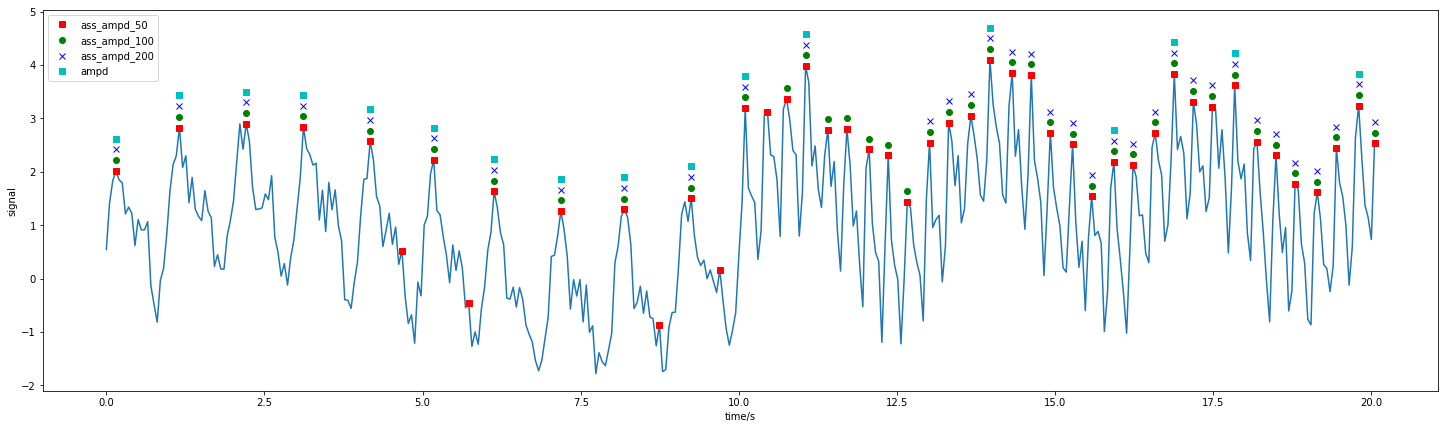

In [39]:
plt.figure(figsize=(25, 7))
plt.plot(t, x, '-')
for idx in range(len(methods)):
    pks = all_pks[idx]
    offset = idx * 0.2
    style = styles[idx]
    name = methods[idx][0]
    plt.plot(t[pks], offset + x[pks], style, label=name)
plt.legend()
plt.xlabel('time/s')
plt.ylabel('signal')

## Compare timing

In [40]:
t, x = fake_timeseries(tmax=200, seed=0)
print('{} samples over {} min'.format(len(x), t[-1]/60))

4000 samples over 3.3333333333333335 min


In [41]:
for name, method in methods:
    print('timing "{}":'.format(name.upper()))
    %time pks = method(x)
    print()

timing "ASS_AMPD_50":
CPU times: user 8.27 ms, sys: 2.26 ms, total: 10.5 ms
Wall time: 3.62 ms

timing "ASS_AMPD_100":
CPU times: user 22 ms, sys: 2.76 ms, total: 24.7 ms
Wall time: 6.31 ms

timing "ASS_AMPD_200":
CPU times: user 38.2 ms, sys: 5.04 ms, total: 43.3 ms
Wall time: 10.9 ms

timing "AMPD":
CPU times: user 135 ms, sys: 8.21 ms, total: 143 ms
Wall time: 36.4 ms



## Profiling

In [42]:
%load_ext line_profiler

In [43]:
%lprun -f find_peaks_ass_ampd pks = find_peaks_ass_ampd(x, window=200)

Timer unit: 1e-06 s

Total time: 0.010374 s
File: /Users/igor/checkouts/ampd/ampd.py
Function: find_peaks_ass_ampd at line 101

Line #      Hits         Time  Per Hit   % Time  Line Contents
   101                                           def find_peaks_ass_ampd(x, window=None, debug=False):
   102                                               """Find peaks in quasi-periodic noisy signals using ASS-AMPD algorithm
   103                                               Adaptive Scale Selection Automatic Multi-Scale Peak Detection, an extension of AMPD -
   104                                               "An Efficient Algorithm for Automatic Peak Detection in
   105                                               Noisy Periodic and Quasi-Periodic Signals", Algorithms 2012, 5, 588-603
   106                                               https://doi.org/10.1109/ICRERA.2016.7884365
   107                                           
   108                                               Optimized

## Adaptive LSM

In [8]:
from scipy.signal import convolve2d

In [15]:
t1, x1 = fake_timeseries(tmax=15, seed=0)
t2, x2 = fake_timeseries(tmax=15, seed=1, dilation=3.1)
t = np.hstack([t1, t1[-1]+ t2 + 1/20])
x = np.hstack([x1, x2 - x2[0] + x1[1]])

In [32]:
pks, LSM, adaptive_scale = find_peaks_ass_ampd(x, window=100, debug=True)
L, N = LSM.shape

51 49
(50, 600) (50, 700)
(50, 700)
(50, 600)


Text(0,0.5,'scale')

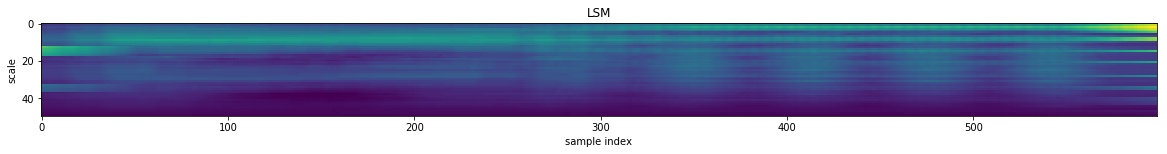

In [29]:
fig, ax0 = plt.subplots(ncols=1, figsize=(20, 7))
ax = ax0
ax.imshow(LSM)
ax.set_title('LSM')
ax.set_xlabel('sample index')
ax.set_ylabel('scale')

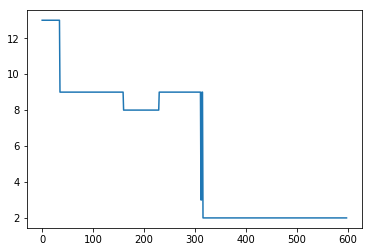

In [30]:
plt.plot(adaptive_scale)

Text(0,0.5,'signal')

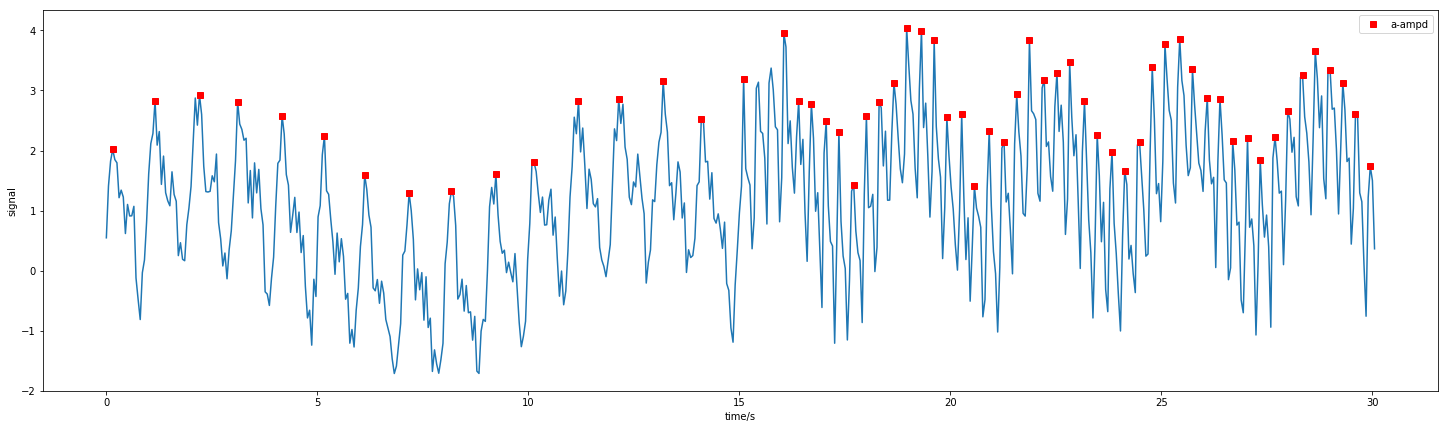

In [31]:
plt.figure(figsize=(25, 7))
plt.plot(t, x, '-')
plt.plot(t[pks], x[pks], 'rs', label='a-ampd')
plt.legend()
plt.xlabel('time/s')
plt.ylabel('signal')